In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import random
import os

In [4]:
# seed 설정
np.random.seed(3)
tf.random.set_seed(3)

# 데이터 파일 불러오기
pd_train = pd.read_csv('2020.AI.bike-train.csv')
pd_test = pd.read_csv('2020.AI.bike-test.csv')

pd_train.head(10)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
5,13,2,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0
6,14,3,10.6,0.0,1.5,58.0,1548.0,0.038,62.0,33.0,23.0
7,16,21,16.0,0.0,6.0,21.0,1961.0,0.050,90.0,28.0,146.0
8,19,9,13.8,0.0,1.9,64.0,1344.0,0.039,93.0,19.0,39.0
9,20,14,17.2,0.0,2.1,32.0,1571.0,0.025,64.0,19.0,83.0


In [5]:
pd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1000 non-null   int64  
 1   hour                    1000 non-null   int64  
 2   hour_bef_temperature    1000 non-null   float64
 3   hour_bef_precipitation  1000 non-null   float64
 4   hour_bef_windspeed      1000 non-null   float64
 5   hour_bef_humidity       1000 non-null   float64
 6   hour_bef_visibility     1000 non-null   float64
 7   hour_bef_ozone          1000 non-null   float64
 8   hour_bef_pm10           1000 non-null   float64
 9   hour_bef_pm2.5          1000 non-null   float64
 10  count                   1000 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 86.1 KB


결측치 없음

### 데이터 시각화

#### 히트맵으로 전체 데이터 상관관계 분석

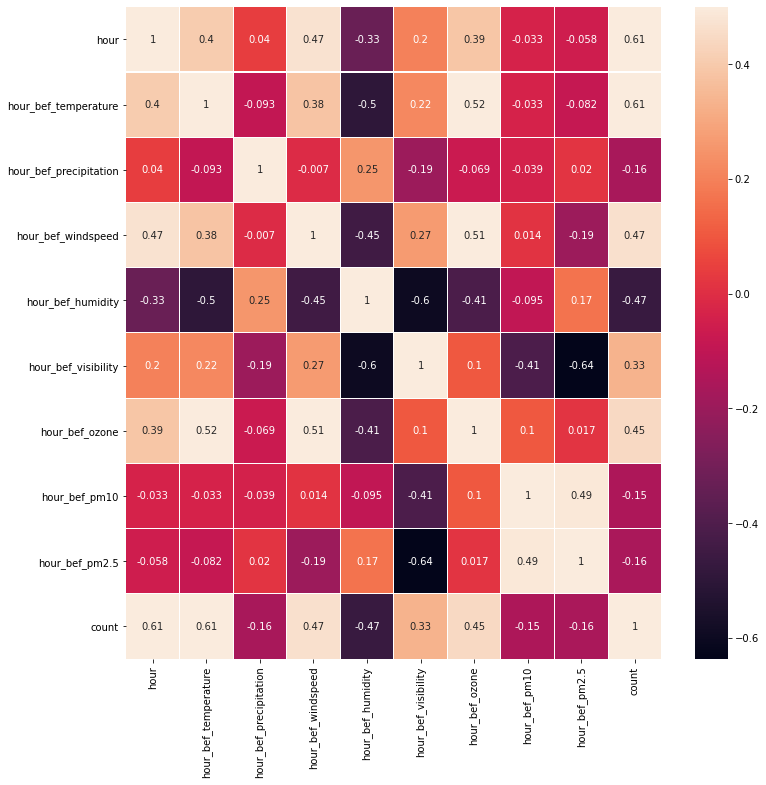

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

map = pd_train.iloc[1:,1:]

plt.figure(figsize=(12,12))
sns.heatmap(map.corr(),linewidths=0.1,annot=True,vmax=0.5)
plt.show()

우리는 count가 중요하니까 count와 연관된 항목을 보면  
시간,온도,풍속이 가장 연관이 높은 것을 알 수 있다.

#### hour과 사용자수 관계도

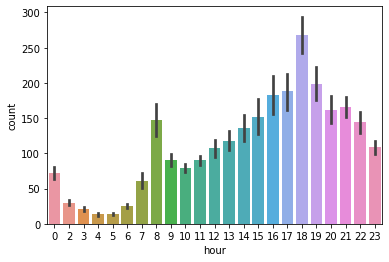

In [7]:
sns.barplot(x='hour',y='count',data=pd_train)

* 16시에서 19시 가장 많이 이용
* 주목할 점은 8시와 18시 사용자수 급증 -> 출퇴근 시 많이 이용하는것으로 예측

####  hour_bef_temperature 와 사용자수 관계

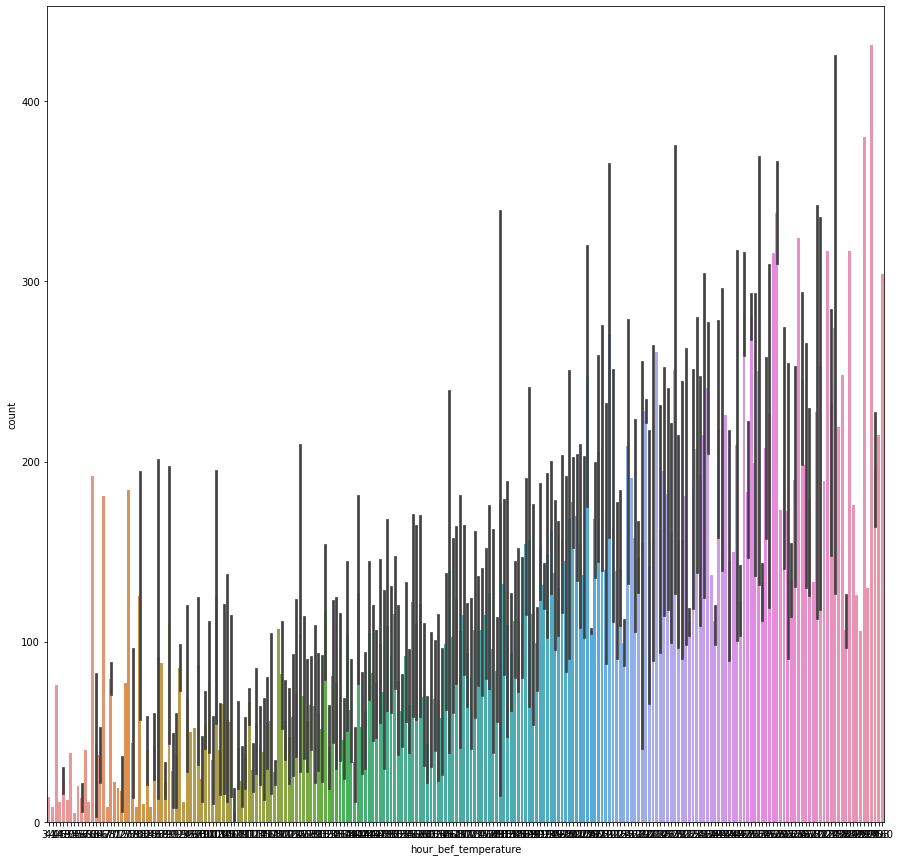

In [8]:
plt.figure(figsize=(15,15)) # 그래프 크기
sns.barplot(x='hour_bef_temperature',y='count',data=pd_train)
plt.show()

* 대체로 온도가 증가함에 따라 사용자수 증가 => 따뜻한 날씨에 많이 이용하는것으로 생각

#### hour_bef_windspeed 와 사용자수 관계

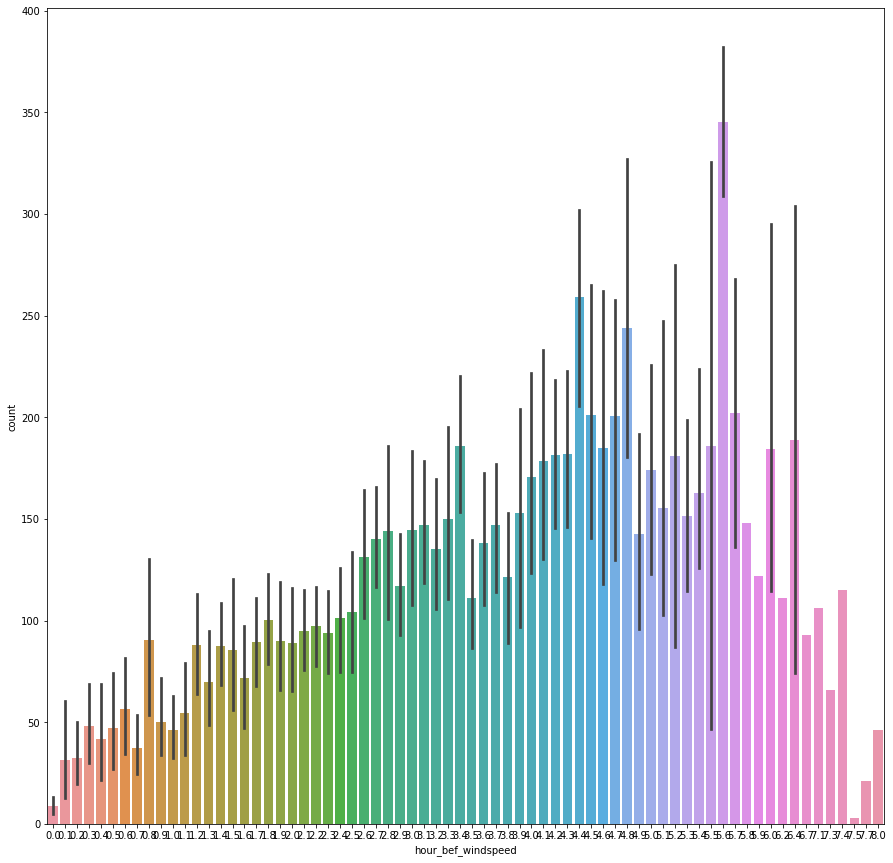

In [9]:
plt.figure(figsize=(15,15))
sns.barplot(x='hour_bef_windspeed',y='count',data=pd_train)
plt.show()

* 풍속이 44 에서 65 정도인 범위에서 사용자가 많고 풍속이 137 이상인 범위에서는 사용자 적음
* 해석: 사용자가 많이 사용하는 온도와 시간대의 풍속이 44~65 범위여서 저렇게 나오는것 같음 

### 데이터 전처리 


In [10]:
x_train = pd_train.iloc[1:,1:-1]
y_train = pd_train.iloc[1:,-1]
print(x_train)
print(y_train)

     hour  hour_bef_temperature  ...  hour_bef_pm10  hour_bef_pm2.5
1      13                  20.1  ...           73.0            40.0
2       6                  13.9  ...           32.0            19.0
3      23                   8.1  ...           75.0            64.0
4      18                  29.5  ...           27.0            11.0
5       2                  13.6  ...           34.0            15.0
..    ...                   ...  ...            ...             ...
995    14                  20.4  ...           23.0            13.0
996    15                  18.5  ...           92.0            83.0
997     4                  16.1  ...           39.0            28.0
998    16                  17.7  ...           64.0            22.0
999     6                  10.7  ...           32.0            28.0

[999 rows x 9 columns]
1      159.0
2       26.0
3       57.0
4      431.0
5       39.0
       ...  
995    108.0
996     78.0
997     27.0
998    118.0
999      5.0
Name: count, Leng

### 모델설계 

In [11]:
model = Sequential()
model.add(Dense(512,input_dim=9,activation='relu'))
model.add(Dense(256,input_dim=9,activation='relu'))
model.add(Dense(128,input_dim=9,activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5120      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 169,473
Trainable params: 169,473
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [12]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=100) # earlystopping을 이용해 과적합 방지

model.fit(x_train,y_train,epochs=1000,batch_size=25,validation_split=0.25,callbacks=[early_stopping_callback])
# 검증셋 이용


Epoch 1/1000
30/30 [==============================] - 1s 14ms/step - loss: 12407.0940 - accuracy: 0.0017 - val_loss: 6133.7930 - val_accuracy: 0.0000e+00
Epoch 2/1000
30/30 [==============================] - 0s 12ms/step - loss: 7568.7730 - accuracy: 0.0038 - val_loss: 5735.5518 - val_accuracy: 0.0000e+00
Epoch 3/1000
30/30 [==============================] - 0s 5ms/step - loss: 7188.1733 - accuracy: 0.0032 - val_loss: 5417.1523 - val_accuracy: 0.0000e+00
Epoch 4/1000
30/30 [==============================] - 0s 5ms/step - loss: 6471.2071 - accuracy: 0.0038 - val_loss: 5178.2441 - val_accuracy: 0.0000e+00
Epoch 5/1000
30/30 [==============================] - 0s 5ms/step - loss: 5772.6334 - accuracy: 0.0046 - val_loss: 4898.0713 - val_accuracy: 0.0000e+00
Epoch 6/1000
30/30 [==============================] - 0s 5ms/step - loss: 6071.5040 - accuracy: 0.0041 - val_loss: 4677.9180 - val_accuracy: 0.0000e+00
Epoch 7/1000
30/30 [==============================] - 0s 5ms/step - loss: 5036.0747 -

In [13]:
print(model.evaluate(x_train,y_train)[1])

32/32 [==============================] - 0s 2ms/step - loss: 1122.5092 - accuracy: 0.0030
0.0030030030757188797


#### 결과
: 정확도

### 테스트 셋 전처리


In [14]:
pd_test

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,1655,4,14.6,0.0,0.6,49.0,2000.0,0.014,41.0,27.0
1,1657,20,21.8,0.0,4.4,40.0,2000.0,0.048,35.0,19.0
2,1660,22,18.3,0.0,1.0,37.0,970.0,0.032,169.0,38.0
3,1662,7,13.2,0.0,0.6,85.0,431.0,0.023,50.0,39.0
4,1663,8,8.9,0.0,0.9,77.0,613.0,0.005,82.0,40.0
...,...,...,...,...,...,...,...,...,...,...
322,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0
323,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0
324,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0
325,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0


id 속성 없앰

In [15]:
test_data = pd_test.iloc[:,1:]
test_data

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,4,14.6,0.0,0.6,49.0,2000.0,0.014,41.0,27.0
1,20,21.8,0.0,4.4,40.0,2000.0,0.048,35.0,19.0
2,22,18.3,0.0,1.0,37.0,970.0,0.032,169.0,38.0
3,7,13.2,0.0,0.6,85.0,431.0,0.023,50.0,39.0
4,8,8.9,0.0,0.9,77.0,613.0,0.005,82.0,40.0
...,...,...,...,...,...,...,...,...,...
322,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0
323,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0
324,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0
325,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0


#### 예측값 생성

In [16]:
y_test = model.predict(test_data)
y_test

array([[ 12.650266 ],
       [253.65108  ],
       [149.07028  ],
       [ 35.08266  ],
       [ 47.757965 ],
       [353.9061   ],
       [ 18.159367 ],
       [184.05042  ],
       [139.75565  ],
       [167.25656  ],
       [ 12.830459 ],
       [214.97354  ],
       [ 27.479174 ],
       [ 10.195973 ],
       [239.80496  ],
       [ 95.781555 ],
       [ 82.14661  ],
       [304.04016  ],
       [100.78088  ],
       [ 76.23964  ],
       [290.5083   ],
       [132.89433  ],
       [ 11.84752  ],
       [111.24722  ],
       [286.4656   ],
       [ 49.501263 ],
       [253.51811  ],
       [191.72638  ],
       [222.71188  ],
       [137.42177  ],
       [ 11.462356 ],
       [ 21.138828 ],
       [ 87.69487  ],
       [262.6117   ],
       [ 97.868355 ],
       [286.98434  ],
       [ 80.23857  ],
       [171.93192  ],
       [ 31.397242 ],
       [162.2767   ],
       [ 66.72587  ],
       [141.63629  ],
       [132.43518  ],
       [ 90.52644  ],
       [186.56587  ],
       [24

#### 예측값 전처리

y_test 를 일차원 리스트로 변환

In [17]:
y_test = y_test.flatten() # [[1],[2]] 를 [1,2]로
y_test

array([ 12.650266 , 253.65108  , 149.07028  ,  35.08266  ,  47.757965 ,
       353.9061   ,  18.159367 , 184.05042  , 139.75565  , 167.25656  ,
        12.830459 , 214.97354  ,  27.479174 ,  10.195973 , 239.80496  ,
        95.781555 ,  82.14661  , 304.04016  , 100.78088  ,  76.23964  ,
       290.5083   , 132.89433  ,  11.84752  , 111.24722  , 286.4656   ,
        49.501263 , 253.51811  , 191.72638  , 222.71188  , 137.42177  ,
        11.462356 ,  21.138828 ,  87.69487  , 262.6117   ,  97.868355 ,
       286.98434  ,  80.23857  , 171.93192  ,  31.397242 , 162.2767   ,
        66.72587  , 141.63629  , 132.43518  ,  90.52644  , 186.56587  ,
       245.17456  ,  59.434414 ,  15.511382 , 114.2909   ,  36.34833  ,
       133.49126  , 197.16357  , 103.412674 , 127.9396   , 262.64325  ,
        38.503162 , 167.29991  ,  90.57056  , 158.71683  , 340.10306  ,
       145.92502  , 142.27931  , 159.88339  , 107.463066 ,  16.387815 ,
       181.5524   , 197.14215  , 143.95987  ,   3.2166376,  10.0

판다스 Dataframe으로 정답 형식 만들기

In [18]:
pd_submit = pd.DataFrame({'id':range(0,327),'count':y_test})
pd_submit

,id,count
0,0,12.650266
1,1,253.651077
2,2,149.070282
3,3,35.082661
4,4,47.757965
...,...,...
322,322,15.215245
323,323,18.516356
324,324,32.094696
325,325,229.647964


#### 제출 파일 csv파일로 만들기

In [19]:
#pd_submit.to_csv("resul1t.csv", index=False,header=True)
pd_submit.to_csv("result3.csv",index = False,header=True)
pd_submit

,id,count
0,0,12.650266
1,1,253.651077
2,2,149.070282
3,3,35.082661
4,4,47.757965
...,...,...
322,322,15.215245
323,323,18.516356
324,324,32.094696
325,325,229.647964


### 결과
:에포크1000, earlystop 100 일때  캐글 42 점

### xgbregressor 모델 사용

In [20]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

#boston = load_boston()
##X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train ,test_size=0.1)
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

#print(len(X_train), len(X_test))
xgb_model.fit(x_train,y_train)

[16:22:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [21]:
predictions = xgb_model.predict(test_data)
predictions

array([ 17.489883 , 217.63637  , 125.65191  ,  43.05552  , 141.5579   ,
       295.13657  ,  26.528217 , 152.83876  , 104.466736 , 112.47594  ,
         5.813888 , 145.69627  ,   7.671132 ,  17.071642 , 273.21582  ,
       120.871605 , 109.67522  , 248.2707   , 128.95218  , 156.73149  ,
       260.0496   , 173.11238  ,  26.814772 ,  90.16904  , 239.87329  ,
        69.25745  , 213.28833  , 137.7329   , 232.7002   , 129.93959  ,
        12.423696 ,  49.389206 ,  99.456184 , 162.27728  ,  89.43887  ,
       312.5289   , 117.32573  , 131.11261  ,  45.91447  , 177.08417  ,
        70.81025  , 156.74973  , 134.17781  , 223.04707  , 149.66582  ,
       217.95134  ,  62.25893  ,  15.565864 ,  95.32553  ,  33.89063  ,
       145.29338  , 207.6258   ,  44.473972 , 135.70618  , 224.25021  ,
        18.719166 ,  88.857796 ,  95.8022   , 170.67662  , 261.03973  ,
       134.86935  , 144.82097  , 115.946465 , 102.5626   ,  18.137047 ,
       143.50357  , 233.08955  , 132.87045  ,  21.266966 ,  19.0

In [22]:
#r_sq = xgb_model.score(x_train, y_train)
#print(r_sq)
#print(explained_variance_score(predictions,y_test))

In [23]:
pd_submit = pd.DataFrame({'id':range(0,327),'count':predictions})
pd_submit

,id,count
0,0,17.489883
1,1,217.636368
2,2,125.651909
3,3,43.055519
4,4,141.557907
...,...,...
322,322,22.455864
323,323,17.406591
324,324,17.147945
325,325,208.259735


In [24]:
pd_submit.to_csv("result4.csv",index = False,header=True)
pd_submit

,id,count
0,0,17.489883
1,1,217.636368
2,2,125.651909
3,3,43.055519
4,4,141.557907
...,...,...
322,322,22.455864
323,323,17.406591
324,324,17.147945
325,325,208.259735


#### 결과 
: 캐글 41점으로 조금 상승